
<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Three: Classifier training and performance assessment. </h2>	

In [180]:
import warnings
warnings.filterwarnings("ignore")

In [181]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split as sksplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

In [182]:
def train_test_split(df):
    return sksplit(df, test_size=0.2, random_state=42)
#Split the data into a training set, and test set 
def accuracy(pred, actual):
    return np.sum(np.equal(pred, actual))/len(pred)
# Calculate the accuracy percentage of the predicted values

In [183]:
X = pd.read_pickle('transformed_data.pkl')
y = pd.read_pickle('transformed_y.pkl')
X_train, X_val = train_test_split(X)
Y_train = y[X_train.index]
Y_val = y[X_val.index]

<h3>  Train models using all of the following methods below. Be sure to drop the actual image column, and the encoding</h3>	Take note of the differences in accuracy, and methods.


## Logistic Regression

In [330]:
from sklearn.linear_model import LogisticRegression

In [331]:
log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=1.0).fit(X_train, Y_train)
training_accuracy = accuracy(log_model.predict(X_train), Y_train)
val_accuracy = accuracy(log_model.predict(X_val), Y_val)
print(training_accuracy, val_accuracy)

0.42470389170896783 0.42905405405405406


In [341]:
log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=1)
selector = RFECV(log_model, step=1, cv=5).fit(X_train, Y_train)
rank=selector.ranking_

In [333]:
rank

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

In [334]:
pens=np.linspace(0.1,5.1,50)
val_acc=[]

for j in range(0,len(pens)):
    log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=pens[j])
    val_acc.append(np.mean(cross_val_score(log_model, X_train, Y_train, cv=5)))

In [292]:
max(val_acc)

0.376106938320493

In [294]:
log_pen=pens[np.argmax(val_acc)]
log_pen

0.5081632653061224

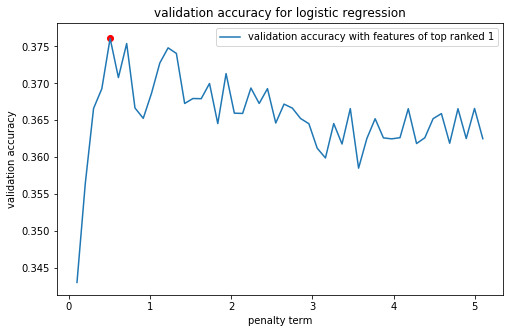

In [295]:
plt.plot(pens, val_acc, label='validation accuracy with features of top ranked '+str(n))
plt.scatter(log_pen, max(val_acc), color='r')
plt.xlabel('penalty term')
plt.ylabel("validation accuracy")
plt.title("validation accuracy for logistic regression")
plt.legend();

In [192]:
columns=X.columns[rank<=n_opt]
X_train_log=X_train[columns]
X_val_log=X_val[columns]

log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=log_pen).fit(X_train_log, Y_train)

training_accuracy = accuracy(log_model.predict(X_train_log), Y_train)
val_accuracy = accuracy(log_model.predict(X_val_log), Y_val)
print(training_accuracy, val_accuracy)

0.42470389170896783 0.42567567567567566


Based on the result of EDA, next we will train logistic classifier on two types of samples, one has image size lower than 300000, and the other has image size larger or equal to 300000, and see if it can provide us a better result.

In [367]:
X_train_small=X_train_log[X_train_log['size']<300000]
Y_train_small=Y_train[X_train_log['size']<300000]
X_val_small=X_val_log[X_val_log['size']<300000]
Y_val_small=Y_val[X_val_log['size']<300000]

X_train_large=X_train_log[X_train_log['size']>=300000]
Y_train_large=Y_train[X_train_log['size']>=300000]
X_val_large=X_val_log[X_val_log['size']>=300000]
Y_val_large=Y_val[X_val_log['size']>=300000]

In [324]:
log_model_small = LogisticRegression(multi_class='ovr', penalty='l1', C=log_pen)
log_model_large = LogisticRegression(multi_class='ovr', penalty='l1', C=log_pen)

training_accuracy_small = accuracy(log_model_small.fit(X_train_small, Y_train_small).predict(X_train_small), Y_train_small)
val_accuracy_small = accuracy(log_model_small.predict(X_val_small), Y_val_small)
print(training_accuracy_small, val_accuracy_small)

training_accuracy_large = accuracy(log_model_large.fit(X_train_large, Y_train_large).predict(X_train_large), Y_train_large)
val_accuracy_large = accuracy(log_model_large.predict(X_val_large), Y_val_large)
print(training_accuracy_large, val_accuracy_large)

print("average training accuracy:")
print((train_accuracy_small*len(X_train_small)+train_accuracy_large*len(X_train_large))/len(X_train_log))

print("average validation accuracy:")
print((val_accuracy_small*len(X_val_small)+val_accuracy_large*len(X_val_large))/len(X_val_log))

0.5 0.5119047619047619
0.34870848708487084 0.3515625
average training accuracy:
0.4306260575296108
average validation accuracy:
0.44256756756756754


### The average validation accuracy for our final logistic regression classifier is 0.44256756756756754, with all features selected and 0.5081632653061224 regularization term.

## K-nearest Neighbors

In [195]:
from sklearn.neighbors import KNeighborsClassifier

Let's first try to fit KNN classifier on the whole dataset

In [239]:
neighbors =range (1, 251, 10)
vals=[]
for n_neighbors in neighbors:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, Y_train)
    training_accuracy = accuracy(knn_model.predict(X_train), Y_train)
    val_accuracy = accuracy(knn_model.predict(X_val), Y_val)
    vals.append(val_accuracy)

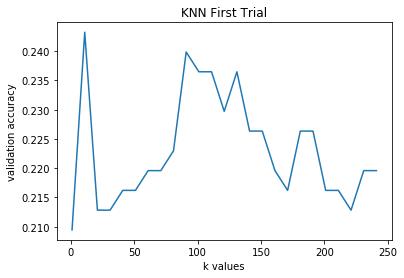

In [240]:
plt.plot(neighbors, vals)
plt.xlabel('k values')
plt.ylabel('validation accuracy')
plt.title("KNN First Trial");

KNN seems to perform better when the k values is between 1-20, so let's get a closer look here.

In [241]:
neighbors =range (1, 20)
vals=[]
for n_neighbors in neighbors:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, Y_train)
    training_accuracy = accuracy(knn_model.predict(X_train), Y_train)
    val_accuracy = accuracy(knn_model.predict(X_val), Y_val)
    vals.append(val_accuracy)

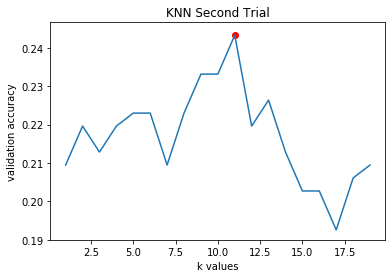

In [242]:
plt.plot(neighbors, vals)
plt.scatter(neighbors[np.argmax(vals)], max(vals), color='r')
plt.xlabel('k values')
plt.ylabel('validation accuracy')
plt.title("KNN Second Trial");

In [200]:
n_neighbors=neighbors[np.argmax(vals)]
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, Y_train)
training_accuracy = accuracy(knn_model.predict(X_train), Y_train)
val_accuracy = accuracy(knn_model.predict(X_val), Y_val)
print(training_accuracy, val_accuracy)

0.3147208121827411 0.24324324324324326


The validation accuracy of the current KNN is 0.24324324324324326, so let's further try to fit KNN on images with small image size and those with large image size separately.

In [201]:
X_tr_sknn=X_train[X_train['size']<300000]
Y_tr_sknn=Y_train[X_train['size']<300000]
X_val_sknn=X_val[X_val['size']<300000]
Y_val_sknn=Y_val[X_val['size']<300000]

X_tr_lknn=X_train[X_train['size']>=300000]
Y_tr_lknn=Y_train[X_train['size']>=300000]
X_val_lknn=X_val[X_val['size']>=300000]
Y_val_lknn=Y_val[X_val['size']>=300000]

In [304]:
neighbors =range (1, 100)
train_small=[]
vals_small=[]
for n_neighbors in neighbors:
    knn_model_small = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_tr_sknn, Y_tr_sknn)
    train_accuracy_small = accuracy(knn_model_small.predict(X_tr_sknn), Y_tr_sknn)
    val_accuracy_small = accuracy(knn_model_small.predict(X_val_sknn), Y_val_sknn)
    train_small.append(train_accuracy_small)
    vals_small.append(val_accuracy_small)

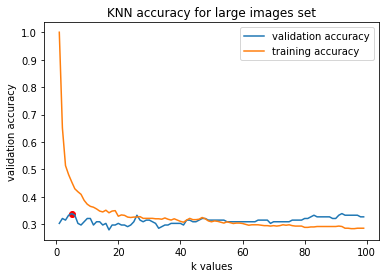

In [305]:
plt.plot(neighbors, vals_small, label='validation accuracy')
plt.plot(neighbors, train_small, label='training accuracy')
plt.scatter(neighbors[np.argmax(vals_small)], max(vals_small), color='r')
plt.xlabel('k values')
plt.legend()
plt.ylabel('validation accuracy')
plt.title("KNN accuracy for large images set");

In [306]:
neighbors =range (1, 100)
train_large=[]
vals_large=[]
for n_neighbors in neighbors:
    knn_model_large = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_tr_lknn, Y_tr_lknn)
    train_accuracy_large = accuracy(knn_model_large.predict(X_tr_lknn), Y_tr_lknn)
    val_accuracy_large = accuracy(knn_model_large.predict(X_val_lknn), Y_val_lknn)
    train_large.append(train_accuracy_large)
    vals_large.append(val_accuracy_large)

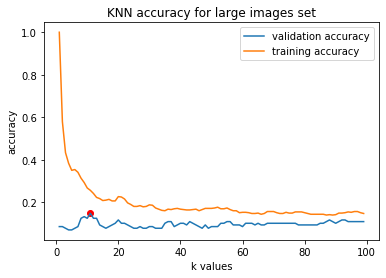

In [307]:
plt.plot(neighbors, vals_large, label='validation accuracy')
plt.plot(neighbors, train_large, label='training accuracy')
plt.scatter(neighbors[np.argmax(vals_large)], max(vals_large), color='r')
plt.xlabel('k values')
plt.legend()
plt.ylabel('accuracy')
plt.title("KNN accuracy for large images set");

In [316]:
print("average training accuracy:")
print((train_small[np.argmax(vals_large)]*len(X_tr_sknn)+train_large[np.argmax(vals_large)]*len(X_tr_lknn))/len(X_train))

average training accuracy:
0.3155668358714044


In [314]:
print("average validation accuracy:")
print((max(vals_small)*len(X_tr_sknn)+max(vals_large)*len(X_tr_lknn))/len(X_train))

average validation accuracy:
0.2517732505438724


In [207]:
neighbors[np.argmax(vals_large)]

11

In [208]:
max(vals_small)

0.3392857142857143

In [209]:
max(vals_large)

0.1484375

### The average validation accuracy for our final KNN classifier is 0.2517732505438724, where the chosen k value is 11, validation accuracy on small images is 0.3392857142857143, and that on big images is 0.1484375.

## Classification Tree

In [210]:
from sklearn.tree import DecisionTreeClassifier

In [327]:
val_acc=[]
train_acc=[]
deps=range(1, 100)
for j in deps:
    dtree_model = DecisionTreeClassifier(max_depth=j).fit(X_train, Y_train)
    train_acc.append(accuracy(dtree_model.predict(X_train), Y_train))
    val_acc.append(accuracy(dtree_model.predict(X_val), Y_val))

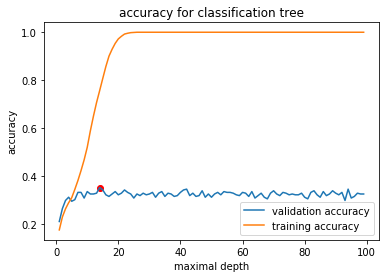

In [277]:
plt.plot(deps, val_acc, label='validation accuracy')
plt.plot(deps, train_acc, label='training accuracy')
plt.scatter(deps[np.argmax(val_acc)], max(val_acc), color='r')
plt.xlabel('maximal depth')
plt.ylabel('accuracy')
plt.title("accuracy for classification tree")
plt.legend();

In [329]:
dtree_model = DecisionTreeClassifier(max_depth=deps[np.argmax(val_acc)]).fit(X_train, Y_train)
train_accuracy = accuracy(dtree_model.predict(X_train), Y_train)
val_accuracy = accuracy(dtree_model.predict(X_val), Y_val)
print(train_accuracy, val_accuracy)

0.7563451776649747 0.35135135135135137


In [279]:
deps[np.argmax(val_acc)]

14

### With chosen max depth value 14, the validation accuracy of the classification tree is 0.35135135135135137.

## Random Forest

In [215]:
from sklearn.ensemble import RandomForestClassifier

In [345]:
forest_model = RandomForestClassifier(n_estimators=100, 
                                    bootstrap = True, 
                                    max_features = 'sqrt', 
                                    max_depth=None)
selector = RFECV(forest_model, step=1, cv=5).fit(X_train, Y_train)
rank=selector.ranking_

In [348]:
rank

array([ 1,  1,  1,  1,  1, 14,  5,  1, 13,  1, 11, 16, 15, 17,  3,  6,  8,
        1,  2,  1, 12,  1, 10,  7,  4,  9,  1])

In [349]:
val_acc=[]
deps=range(1,25)
fets=range(1, max(rank)+1)
val_acc=[[0 for i in range(0, len(deps))] for j in range(0, len(fets))]

for i in range(0,len(fets)):
    n=fets[i]
    X_r=X_train[X_train.columns[rank<=n]]
    for j in range(0,len(deps)):
        forest_model = RandomForestClassifier(n_estimators=100, 
                                                      bootstrap = True, 
                                                      max_features = 'sqrt', 
                                                      max_depth=deps[j])

        val_acc[i][j] = np.mean(cross_val_score(forest_model, X_r, Y_train, cv=5))

In [258]:
val_mat = np.matrix(val_acc)
a,b=np.unravel_index(val_mat.argmax(), val_mat.shape)
val_mat[a,b]

0.3828944520375054

In [363]:
n_opt=fets[a]
rf_dep=deps[b]

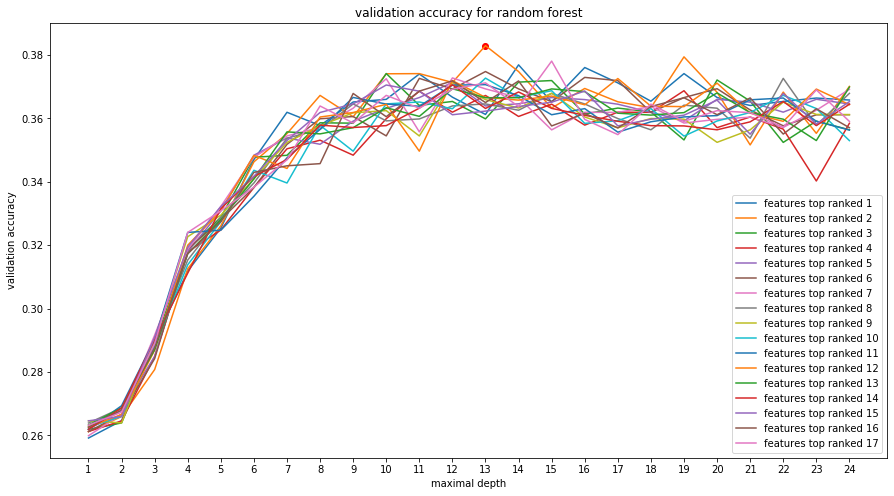

In [274]:
plt.figure(figsize=(15,8))
#plt.plot(deps, train_acc, label='train accuracy')
for i in range(0,len(fets)):
    n=fets[i]
    plt.plot(deps, val_acc[i], label='features top ranked '+str(n))
plt.scatter(rf_dep, val_mat[a,b], color='r')
plt.xticks(deps)
plt.legend()
plt.xlabel('maximal depth')
plt.ylabel('validation accuracy')
plt.title("validation accuracy for random forest");

In [261]:
rf_dep

13

In [267]:
n_opt

2

In [269]:
X.columns[rank<=n_opt]

Index([       'size',     'red_avg', 'aspectratio',   'green_avg',
          'blue_avg',    'blue_std',    'colorful',             3,
                   4,             5,             7,            12],
      dtype='object')

In [222]:
columns=X.columns[rank<=n_opt]
X_train_rf=X_train[columns]
X_val_rf=X_val[columns]

forest_model = RandomForestClassifier(n_estimators=100, 
                                      bootstrap = True, 
                                      max_features = 'sqrt', 
                                      max_depth=rf_dep).fit(X_train_rf, Y_train)
training_accuracy = accuracy(forest_model.predict(X_train_rf), Y_train)
val_accuracy = accuracy(forest_model.predict(X_val_rf), Y_val)
print(training_accuracy, val_accuracy)

0.9923857868020305 0.40878378378378377


### With 12 features selected and maximal depth 13, the validation accuracy of our final random forest is 0.40878378378378377.

## Support Vector Machine

In [223]:
from sklearn.svm import SVC

In [224]:
svc_model = SVC(C=1.0, tol=2).fit(X_train, Y_train)
training_accuracy = accuracy(svc_model.predict(X_train), Y_train)
print(training_accuracy)

1.0


In [271]:
tols= range(1, 10)
val_svm=[]
train_svm=[]
for t in tols:
    svc_model = SVC(C=1.0, tol=t).fit(X_train, Y_train)
    training_accuracy = accuracy(svc_model.predict(X_train), Y_train)
    val_accuracy = accuracy(svc_model.predict(X_val), Y_val)
    val_svm.append(val_accuracy)
    train_svm.append(training_accuracy)

In [272]:
t = tols[val_svm.index(max(val_svm))]
t

2

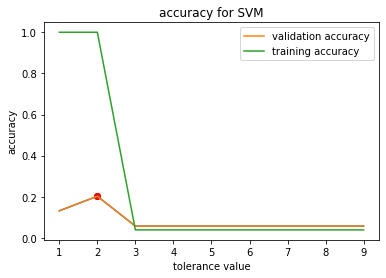

In [273]:
plt.plot(tols, val_svm)
plt.scatter(t, max(val_svm), color='r')
plt.xlabel('tolerance value')
plt.ylabel('validation accuracy');

plt.plot(tols, val_svm, label='validation accuracy')
plt.plot(tols, train_svm, label='training accuracy')
plt.scatter(t, max(val_svm), color='r')
plt.xlabel('tolerance value')
plt.ylabel('accuracy')
plt.title("accuracy for SVM")
plt.legend();

In [228]:
svc_model = SVC(C=1.0, tol=t).fit(X_train, Y_train)
training_accuracy = accuracy(svc_model.predict(X_train), Y_train)
val_accuracy = accuracy(svc_model.predict(X_val), Y_val)
print(val_accuracy)

0.20270270270270271


Let's also try to tune regularization parameter, C.

In [308]:
cs = np.linspace(0.1,5.1,20)
val_svm=[]
train_svm=[]
for c in cs:
    svc_model = SVC(C=c, tol=t).fit(X_train, Y_train)
    training_accuracy = accuracy(svc_model.predict(X_train), Y_train)
    val_accuracy = accuracy(svc_model.predict(X_val), Y_val)
    val_svm.append(val_accuracy)
    train_svm.append(training_accuracy)

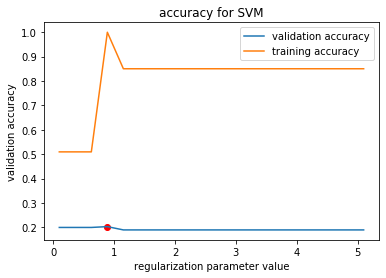

In [309]:
plt.plot(cs, val_svm, label='validation accuracy')
plt.plot(cs, train_svm, label='training accuracy')
plt.scatter(cs[np.argmax(val_svm)], max(val_svm), color='r')
plt.xlabel('regularization parameter value')
plt.ylabel('validation accuracy')
plt.title("accuracy for SVM")
plt.legend();

But the result validation accuracy is still very low and doesn't improve much, so we still keep C as 1.

In [319]:
svc_model = SVC(C=1.0, tol=t).fit(X_train, Y_train)
training_accuracy = accuracy(svc_model.predict(X_train), Y_train)
val_accuracy = accuracy(svc_model.predict(X_val), Y_val)
print(training_accuracy, val_accuracy)

1.0 0.20270270270270271


### The validation accuracy of our SVM classifier, with C=1 and tol=2,  is 0.20270270270270271.

## Test on test data

In [369]:
test_data=pd.read_pickle("transformed_data_test.pkl")
X_test=test_data

In [370]:
X_test

,size,red_avg,aspectratio,green_avg,blue_avg,red_std,green_std,blue_std,grey_std,colorful,...,3,4,5,6,7,8,9,10,11,12
Id,,,,,,,,,,,,,,,,,,,,,
0,1620000,105.980433,0.666667,106.905494,105.590887,67.205121,65.316848,63.113690,0.256376,171.341564,...,0.195856,0.090930,0.229172,0.326415,0.163256,0.193094,0.241652,0.320611,0.175981,0.184913
1,91821,144.792694,0.526971,147.593426,133.982324,79.839361,77.287288,76.796918,0.304696,159.033671,...,0.187800,0.309406,0.171333,0.148888,0.169634,0.193387,0.213023,0.167576,0.174601,0.198288
2,312006,133.637670,1.171141,123.831301,118.584796,68.821922,72.801423,82.262728,0.284262,175.422400,...,0.182045,0.213611,0.207583,0.199640,0.262158,0.120603,0.246005,0.248524,0.203775,0.085854
3,70308,96.696962,0.656085,83.622675,85.577701,61.854443,52.434449,48.460702,0.212077,147.802648,...,0.115250,0.045272,0.377197,0.162869,0.402842,0.029613,0.353175,0.170507,0.425329,0.043480
4,244650,23.246266,1.502146,40.598455,46.887554,25.818695,28.859210,34.166635,0.111580,93.570925,...,0.008964,0.001116,0.779031,0.183814,0.018418,0.015769,0.672410,0.274568,0.028093,0.016542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,1229580,82.298175,0.624691,88.592117,138.559137,33.266301,34.144022,46.221502,0.135341,73.953556,...,0.004816,0.012775,0.112834,0.568309,0.301086,0.005063,0.044588,0.173432,0.356888,0.384092
712,490032,101.633914,0.658635,128.388609,163.542010,67.142158,70.383417,65.551384,0.266364,88.947355,...,0.045015,0.124167,0.115884,0.333437,0.237352,0.127602,0.093178,0.066896,0.232950,0.334545
713,185115,96.093250,0.749129,126.238344,162.929860,53.152277,59.381154,72.718032,0.229114,82.100547,...,0.068131,0.038814,0.171542,0.116684,0.434584,0.198558,0.079540,0.178154,0.088145,0.345288


In [373]:
X_test_log=X_test

X_test_small=X_test_log[X_test_log['size']<300000]

X_test_large=X_test_log[X_test_log['size']>=300000]

In [374]:
y_hat_small=log_model_small.predict(X_test_small)
y_hat_small=pd.DataFrame({
    'index':X_test_small.index,
    'encoding':y_hat_small
})

y_hat_large=log_model_large.predict(X_test_large)
y_hat_large=pd.DataFrame({
    'index':X_test_large.index,
    'encoding':y_hat_large
})

In [375]:
y_hat=pd.concat([y_hat_small, y_hat_large])
y_hat=y_hat.sort_values(by='index').set_index(keys='index')
y_hat

,encoding
index,
0,19
1,0
2,5
3,12
4,3
...,...
711,11
712,11
713,6


In [376]:
y_hat.to_csv('predictions2.csv', index=False, header=False)